# Maximum Likelihood vs CDF Fit (Spiral B)

In [303]:
import matplotlib.pyplot as plot
from math import sqrt
from scipy.optimize import curve_fit

import DistA
import MaxLikeEst as Mle

from LocUtil import Grid1, SetSeed
from LocMath import RandLog
from StopWatch import StopWatch

#### Constants

In [247]:
minN = 30
maxN = 3_000
nN = 100

givenSeed = None
seedDig = 3

nPlot = 101

### Generate a list of 'N' values

In [248]:
seed = SetSeed(givenSeed,seedDig)
seed

383

In [249]:
aTrue = 0.3

In [250]:
nL = tuple(sorted(round(RandLog(minN,maxN)) for _ in range(nN))) 
nL[:10]

(31, 32, 32, 34, 35, 38, 38, 39, 43, 45)

Text(0, 0.5, 'Quantile')

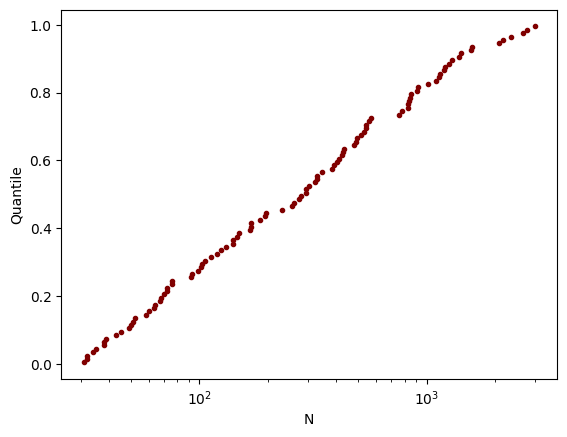

In [251]:
q = tuple((k + 0.5)/nN for k in range(nN))

plot.semilogx(tuple(nL),q, '.', color='maroon')

plot.xlabel('N')
plot.ylabel('Quantile')

## Accuracy for Maximum Likelihood Estimation

In [282]:
import importlib
importlib.reload(Mle)

<module 'MaxLikeEst' from 'F:\\Users\\Kenne.DESKTOP-BT6VROU\\Documents\\GitHub\\ManetSim\\2dDist\\MaxLikeEst.py'>

In [283]:
timer = StopWatch(running=True)

aEst = []
for n in nL:
	fuckPy = (DistA.GenSamp(aTrue) for _ in range(n))
	aEst.append(Mle.MaxLikeDistA(fuckPy))
	
timer.Stop()
print(timer.Delta())

0:05:06.371109


In [307]:
err = tuple(est - aTrue for est in aEst)
errAbs = tuple(abs(e) for e in err)

In [308]:
def form(nL, k0,k1):
	result = tuple(k0 / n**k1 for n in nL)
	return result

In [311]:
optParam,_ = curve_fit(form, nL,errAbs)
k0,k1 = optParam
k0,k1

(6.334035784761518, 0.8686625288731233)

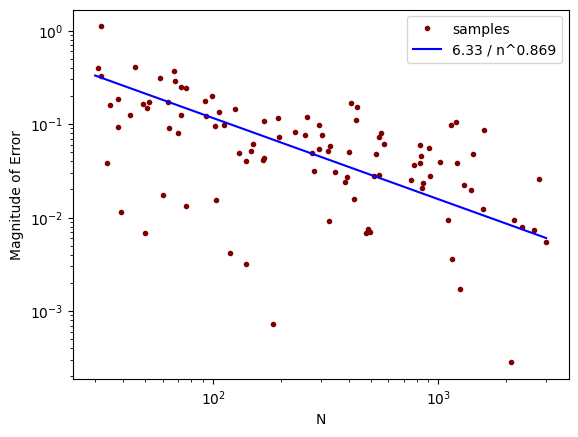

In [316]:
plot.loglog(nL, errAbs, '.', color='maroon', label='samples')

nGrid = Grid1(minN,maxN, nPlot)
fitGrid = [k0 / n**k1 for n in nGrid]
text = f'{k0:.2f} / n^{k1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()